In [1]:
import logging, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
import scipy
import pandas as pd

### Walk through the data

In [2]:
### Walk through all directory and files
for dir_path, dir_name, file_name in os.walk("data"):
    print(f"There are {len(dir_name)} directories and {len(file_name)} images in '{dir_path}'.")

There are 3 directories and 0 images in 'data'.
There are 2 directories and 0 images in 'data\test'.
There are 0 directories and 234 images in 'data\test\normal'.
There are 0 directories and 390 images in 'data\test\pneumonia'.
There are 2 directories and 0 images in 'data\train'.
There are 0 directories and 1341 images in 'data\train\normal'.
There are 0 directories and 3875 images in 'data\train\pneumonia'.
There are 2 directories and 0 images in 'data\val'.
There are 0 directories and 8 images in 'data\val\normal'.
There are 0 directories and 8 images in 'data\val\pneumonia'.


In [3]:
### Another way find how many images
number_pneumonia_images_train = len(os.listdir("data/train/pneumonia"))

number_pneumonia_images_train

3875

In [4]:
### Get the class names
data_train_dir = pathlib.Path("data/train/")
class_names = np.array(sorted([item.name for item in data_train_dir.glob('*')]))

print(class_names)

['normal' 'pneumonia']


In [5]:
### Viewing image
def view_image(target_dir, target_class):
    target_folder = target_dir + target_class

    # Get random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read image then plot it using matplotlib
    # img = mpimg.imread(target_folder + "/" + random_image[0])
    img = cv2.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");
    
    return img

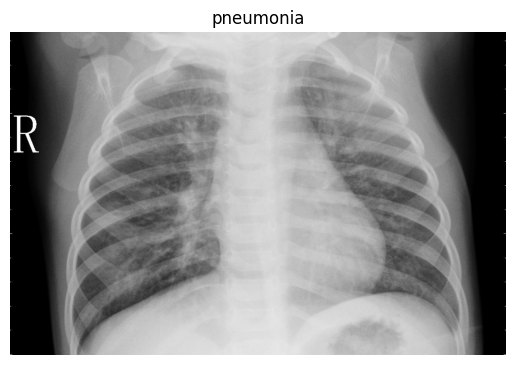

In [6]:
### View random image from the training dataset
img = view_image(target_dir = "data/train/", target_class = "pneumonia")     

In [7]:
### View the images, just a big array/tensor
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  8,   8,   8],
        [ 25,  25,  25],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 26,  26,  26],
        [  3,   3,   3]],

       [[251, 251, 251],
        [234, 234, 234],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [235, 235, 235],
        [249, 249, 249]],

       [[  0,   0,   0],
        [ 15,  15,  15],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [ 14,  14,  14],
        [  0,   0,   0]]

In [8]:
### View image shape, there are 2 channels
img.shape

(840, 1288, 3)

In [9]:
### Get all the pixel values between 0 & 1
img/ 255. 

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.03137255, 0.03137255, 0.03137255],
        [0.09803922, 0.09803922, 0.09803922],
        [0.        , 0

### Data preprocessing

In [10]:
### Set seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale = 1./ 255)
val_datagen = ImageDataGenerator(rescale = 1./ 255)
test_datagen = ImageDataGenerator(rescale = 1./ 255)

train_dir_path = "data/train/"
val_dir_path = "data/val/"
test_dir_path = "data/test/"

train_data = train_datagen.flow_from_directory(train_dir_path, batch_size = 32, target_size = (150, 150), 
    class_mode = "binary", seed = 42)
val_data = val_datagen.flow_from_directory(val_dir_path, batch_size = 32, target_size = (150, 150),
    class_mode = "binary", seed = 42)
test_data = test_datagen.flow_from_directory(test_dir_path, batch_size = 32, target_size = (150, 150),
    class_mode = "binary", seed = 42)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [12]:
### Create sequential model
model = Sequential()

### First layer
model.add(Conv2D(32, input_shape = (150, 150, 3), kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Second layer
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Flatten layer
### Can be GlobalAveragePooling2D or Flatten
### model.add(GlobalAveragePooling2D())
model.add(Flatten())

### Fully connected dense layer
model.add(Dense(128, activation = 'relu'))

### Output layer
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [15]:
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], 
              optimizer = tf.keras.optimizers.RMSprop())

history = model.fit(train_data, epochs = 5,
    steps_per_epoch = len(train_data), validation_data = val_data, validation_steps = len(val_data))

Epoch 1/5
163/163 [==============================] - 105s 640ms/step - loss: 0.0536 - accuracy: 0.9845 - val_loss: 0.0610 - val_accuracy: 1.0000
Epoch 2/5
163/163 [==============================] - 104s 636ms/step - loss: 0.0272 - accuracy: 0.9904 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 3/5
163/163 [==============================] - 101s 621ms/step - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.4552 - val_accuracy: 0.8125
Epoch 4/5
163/163 [==============================] - 99s 606ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.0209 - val_accuracy: 1.0000
Epoch 5/5
163/163 [==============================] - 101s 617ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0752 - val_accuracy: 0.9375


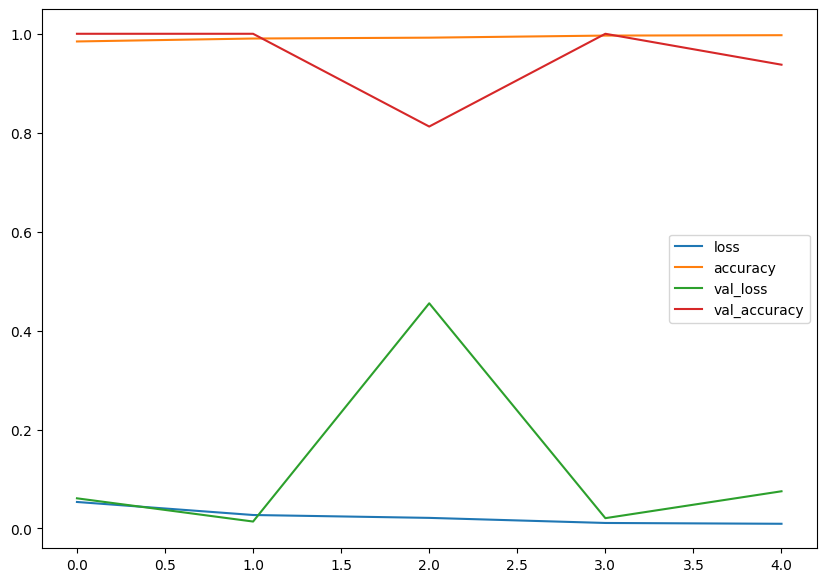

In [16]:
# Plot the training curves
pd.DataFrame(history.history).plot(figsize = (10, 7));

### Reference
1. https://www.researchgate.net/publication/367339121_Pneumonia_Detection_in_Chest_X-Ray_Images_Handling_Class_Imbalance